# Exercise 4: Error Analysis

This exercise examines the statisically computed errors and how they relate to correlations between configurations. Binning, Jacknifing and Bootstrapping are all examined.

### Potentials

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import vegas
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

#Harmonic
def v_sho(x):
    
    return (x**2)/2

#Anharmonic
def v_aho(x):
    
    return (x ** 4)/2


### Action for One Spatial Point

In [16]:
def action(x, i, v, m, a): 
    ir = (i+1)%len(x) 
    il = (i-1)%len(x)
    return a *  v(x[i]) + (m/a) * x[i] * (x[i]-x[ir]-x[il])

### Update Function

In [17]:
def update(x, v, m, a, dx):
    #Updates Every Point Once
    accept = 0
    for i in range(len(x)):
        
        x_old = x[i]
        old_action = action(x=x, i=i, v=v, m=m, a=a)
        
        x[i] += np.random.uniform(-dx, dx)
        new_action = action(x=x, i=i, v=v, m=m, a=a)
        
        diff = old_action - new_action
        
        r = np.minimum(1.0, np.exp(diff))
    
        if r < np.random.rand():
            x[i] = x_old
        
        else:
            accept += 1
    
    return x, accept / len(x)

### Two Point Function

In [18]:
def G(x):
    #Returns Array Gn = [G1, G2,...]
    n = len(x)
    g = np.zeros(n)
    for j in range(n):
        for i in range(n):
            g[j] += (x[(i+j)%(n)]) *(x[i])
            
    return g/n

### Markov Chain Generation

In [19]:
def markov_chain(n_sites, n_configs, v, m, a, dx, n_corr):
    
    acceptance = 0
    config = np.zeros((n_sites))
    gn = []
    
    #Thermalise
    for i in range(10*n_corr):
        config = update(config, v, m, a, dx)[0]


    for i in range(n_configs*n_corr):
        config, acc = update(config, v, m, a, dx)
        acceptance += acc
        
        if i % n_corr == 0:
            gn.append(G(config))
            
    acceptance = acceptance / (n_configs*n_corr)       
    return gn, acceptance

### Binning 

In [20]:
def binning(g, bin_size):
    g_bin = []
    Ncf = len(g)
    for i in range(0, Ncf, bin_size):
        bin_val = np.mean(g[i:i+bin_size],0)
        g_bin.append(bin_val)
    return g_bin

def jacknife(g):
    g_jacknife = []
    Ncf = len(g)
    for i in range(Ncf):
        b = np.delete(g,i,0)
        jknife_avg = np.mean(b, 0)
        g_jacknife.append(jknife_avg)
    return g_jacknife

def bootstrap(g, n_samples):
    g_bootstrap = []
    Ncf = len(g)
    for j in range(n_samples):
        g_bootstrap_j = []
        for i in range(len(g)):
            alpha = int(np.random.uniform(0, Ncf))
            g_bootstrap_j.append(g[alpha])
        g_bootstrap_j_avg = np.mean(g_bootstrap_j, 0)
        g_bootstrap.append(g_bootstrap_j_avg)
    return g_bootstrap
    
        
        
def analysis_binned(n_sites, n_cfs_arr, v, m, a, dx, n_corr, bin_size, harmonic=True):
    
    rows = len(n_cfs_arr)
    fig, axs =  plt.subplots(nrows=rows, ncols=4, figsize=(12, 10), dpi=100)
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    ax = axs.flat
    
    for i, n_configs in enumerate(n_cfs_arr):
        gn, acc = markov_chain(n_sites=n_sites, n_configs=n_configs, v=v, m=m, a=a, dx=dx, n_corr=n_corr)
        
        binned_g = binning(g=gn, bin_size=bin_size)
        jacknife_g = jacknife(g=gn)
        bootstrap_g = bootstrap(g=gn, n_samples = n_configs)
        
        t = np.arange(0, n_sites * a, a)

        ######################################################################################################
        # Original G
        
        avg = np.mean(gn,0)
        err = np.std(gn,0) / np.sqrt(n_configs)
        avg_shift = np.roll(avg, -1)
        err_shift = np.roll(err, -1)
        
        E_eff = np.log(np.divide(avg,avg_shift)) / a
        E_eff_err = np.sqrt(np.divide(err, avg)**2 + np.divide(err_shift, avg_shift)**2)/ a / np.sqrt(n_configs)
        
        
        ax[4*i].errorbar(t, E_eff, yerr=E_eff_err, fmt='o',  markersize=2, color='k')
        ax[4*i].tick_params(bottom="off", top="off", left="off", right="off")
        ax[4*i].set_title("Original" + "(" + str(n_configs) + ")")
        ax[4*i].set_xlim(0, 10)
        ax[4*i].set_ylim(-2, 2)
        ax[4*i].set_xticks([0, 2, 4, 6, 8, 10])
        ax[4*i].set_yticks([-2, -1, 0, 1, 2])
        if harmonic == True:
            ax[4*i].axhline(y=1, color='r', linestyle='-')
        
        #######################################################################################################
        # Binned
        
        avg_binned = np.mean(binned_g, 0)
        err_binned = np.std(binned_g, 0)
        avg_shift_binned = np.roll(avg_binned, -1)
        err_shift_binned = np.roll(err_binned, -1)
        
        E_eff_binned = np.log(np.divide(avg_binned, avg_shift_binned)) / a
        E_eff_err_binned = np.sqrt(np.divide(err_binned, avg_binned)**2 + np.divide(err_shift_binned, avg_shift_binned)**2)/ a / np.sqrt(n_configs/bin_size)
        
        ax[4*i+1].errorbar(t, E_eff_binned, yerr=E_eff_err_binned, fmt='o',  markersize=2, color='k')
        ax[4*i+1].tick_params(bottom="off", top="off", left="off", right="off")
        ax[4*i+1].set_title("Binned" + "(" + str(n_configs) + ")")
        ax[4*i+1].set_xlim(0, 10)
        ax[4*i+1].set_ylim(-2, 2)
        ax[4*i+1].set_xticks([0, 2, 4, 6, 8, 10])
        ax[4*i+1].set_yticks([-2, -1, 0, 1, 2])
        if harmonic == True:
            ax[4*i+1].axhline(y=1, color='r', linestyle='-')
        
        #######################################################################################################
        # Jacknife
        
        avg_jacknife = np.mean(jacknife_g, 0)
        err_jacknife = np.std(jacknife_g, 0)
        avg_shift_jacknife = np.roll(avg_jacknife, -1)
        err_shift_jacknife = np.roll(err_jacknife, -1)
        
        E_eff_jacknife = np.log(np.divide(avg_jacknife, avg_shift_jacknife)) / a
        E_eff_err_jacknife = np.sqrt(np.divide(err_jacknife, avg_jacknife)**2 + np.divide(err_shift_jacknife, avg_shift_jacknife)**2)/ a * np.sqrt(n_configs-1)
        
        
        ax[4*i+2].errorbar(t, E_eff_jacknife, yerr=E_eff_err_jacknife, fmt='o',  markersize=2, color='k')
        ax[4*i+2].tick_params(bottom="off", top="off", left="off", right="off")
        ax[4*i+2].set_title("Jacknife" + "(" + str(n_configs) + ")")
        ax[4*i+2].set_xlim(0, 10)
        ax[4*i+2].set_ylim(-2, 2)
        ax[4*i+2].set_xticks([0, 2, 4, 6, 8, 10])
        ax[4*i+2].set_yticks([-2, -1, 0, 1, 2])
        if harmonic == True:
            ax[4*i+2].axhline(y=1, color='r', linestyle='-')

        
        #######################################################################################################
        # Bootstrap
        
        avg_bootstrap = np.mean(bootstrap_g, 0)
        err_bootstrap = np.std(bootstrap_g, 0)
        avg_shift_bootstrap = np.roll(avg_bootstrap, -1)
        err_shift_bootstrap = np.roll(err_bootstrap, -1)
        
        E_eff_bootstrap = np.log(np.divide(avg_bootstrap, avg_shift_bootstrap)) / a
        E_eff_err_bootstrap = np.sqrt(np.divide(err_bootstrap, avg_bootstrap)**2 + np.divide(err_shift_bootstrap, avg_shift_bootstrap)**2)/ a / np.sqrt(n_configs)
  
        ax[4*i+3].errorbar(t, E_eff_bootstrap, yerr=E_eff_err_bootstrap, fmt='o',  markersize=2, color='k')
        ax[4*i+3].tick_params(bottom="off", top="off", left="off", right="off")
        ax[4*i+3].set_title("Bootstrap" + "(" + str(n_configs) + ")")
        ax[4*i+3].set_xlim(0, 10)
        ax[4*i+3].set_ylim(-2, 2)
        ax[4*i+3].set_xticks([0, 2, 4, 6, 8, 10])
        ax[4*i+3].set_yticks([-2, -1, 0, 1, 2])
        if harmonic == True:
            ax[4*i+3].axhline(y=1, color='r', linestyle='-')
    
        
    plt.show()
    
    

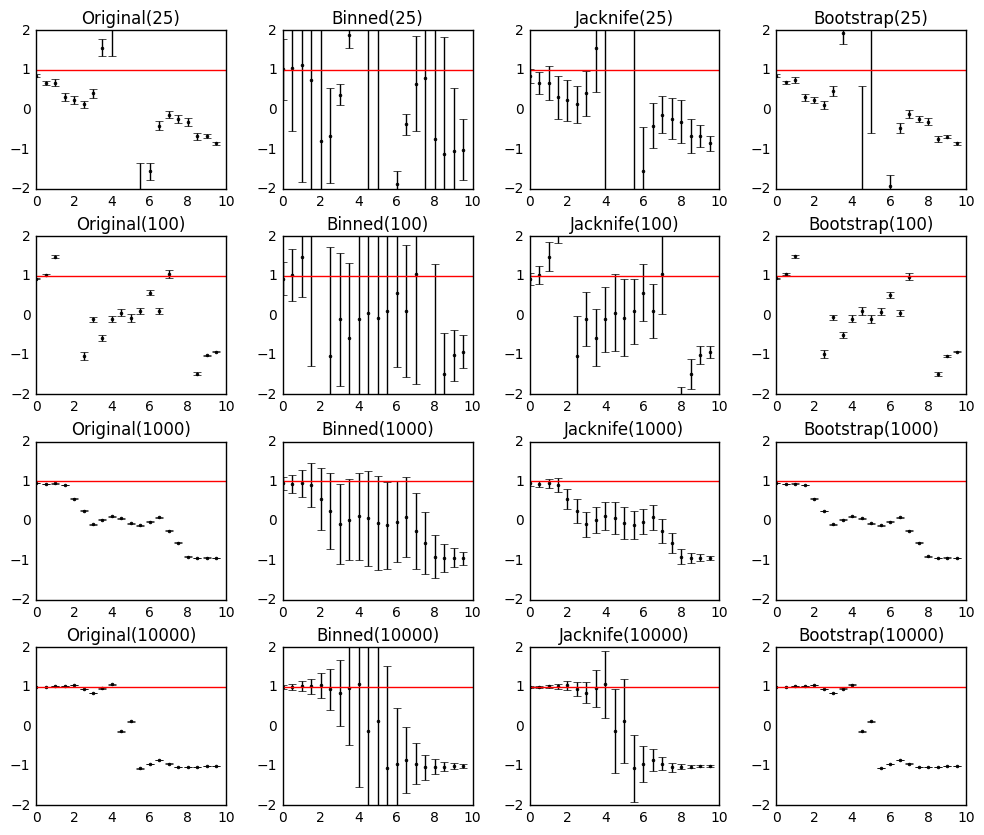

In [21]:
analysis_binned(n_sites=20, n_cfs_arr=[25,100, 1000, 10000], v=v_sho, m=1, a=0.5, dx=1.4, n_corr=1, bin_size = 20)

#### Question

For binning errors do I divide by the square root of the original number of configs or number of configs / bin size.

Not possible to fit or preform functional operations on a single configuration (They flucuate too wildy). Need to average then preform fit / operations. Have to propagate errors!

If I bin, can I then preform these fits/ operations on a single binned configuration and then calculate the error on the final ensemble of fits / functionally changed data.

How about jacknife and bootstrap? How many configurations do i need to average to create a new ensemble that I can analyse individual configurations?

Are my bootstrap, jacknife, binning errors correct?